In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.9 MB/s eta 0:00:00


In [2]:
import bitsandbytes as bnb
from transformers import (
AutoModelForCausalLM,
AutoTokenizer,
BitsAndBytesConfig,
AutoTokenizer,
TrainingArguments,
)
from peft import *
from accelerate import Accelerator
from datasets import load_dataset, list_datasets
from trl import SFTTrainer
import torch

#### Load Dataset

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
data = load_dataset("j03x/CheckThat2023")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'sentence', 'label', 'solved_conflict'],
        num_rows: 830
    })
    validation: Dataset({
        features: ['sentence_id', 'sentence', 'label', 'solved_conflict'],
        num_rows: 219
    })
})

In [6]:
data['train'] = data['train'].remove_columns(['sentence_id', 'solved_conflict'])
data['validation'] = data['validation'].remove_columns(['sentence_id', 'solved_conflict'])


data_validation_unlabeled = data['validation'].remove_columns(['label'])

In [7]:
data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 830
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 219
    })
})

In [8]:
data_validation_unlabeled

Dataset({
    features: ['sentence'],
    num_rows: 219
})

In [11]:
for sample in data_validation_unlabeled:
  print(sample)

{'sentence': '(It’s also true that Alien Nation was “a masterpiece of precision,” but that’s by the way.)'}
{'sentence': 'It’s all justified in the name of racial “equity.” But it’s nothing more than a nice way of saying they want to destroy the Historic American Nation.'}
{'sentence': 'These issues include punishing Sanctuary Cities and increasing deportations.'}
{'sentence': 'Only 20 percent of voters support it, while a third aren’t quite sure what it is [Poll: Nearly Half of Registered Voters Oppose Teaching of Critical Race Theory, by Susan Berry, Breitbart, November 16, 2021].'}
{'sentence': 'In contrast, in 2017 fewer than half of Republicans said minorities are favored over whites.'}
{'sentence': 'In part this is because the deleterious situation surrounding housing in the UK—a common feature of these columns—plays such a large, oversized role in economic and social life.'}
{'sentence': 'The Immigration Invasion symbolizes a lot about the present state of the immigration debate

#### Create Formatted Prompt

In the following function we'll be merging our `sentence` and `label` columns by creating the following template:

```
<s>### Instruction:
Subjectivity is a characteristic of language: by uttering a statement, the speaker simultaneously expresses his or her position, attitude and feelings towards the statement, thus leaving his or her own mark. If the text is not subjective, it is considered subjective. There are a few points to clarify: 1. emotions, considered objective because there is no more objective way of describing them. 2. quotations, considered objctive whatever their content. 3. Intensifiers, considered subjective 4. Speculation, considered subjective. [Answer only OBJ for objective or SUB for subjective].

### Input:
{input}

### Response:
{response}</s>
```

In [12]:
def create_prompt(sample):
  bos_token = "<s>"
  original_system_message = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
  system_message = "Subjectivity is a characteristic of language: by uttering a statement, the speaker simultaneously expresses his or her position, attitude and feelings towards the statement, thus leaving his or her own mark. If the text is not subjective, it is considered subjective. There are a few points to clarify: 1. emotions, considered objective because there is no more objective way of describing them. 2. quotations, considered objctive whatever their content. 3. Intensifiers, considered subjective 4. Speculation, considered subjective. [Answer only OBJ for objective or SUB for subjective]."

  #label = sample["label"].replace(original_system_message, "").replace("\n\n### Sentence\n", "").replace("\n### label\n", "").strip()
  input = sample["sentence"]
  eos_token = "</s>"

  full_prompt = ""
  full_prompt += bos_token
  full_prompt += "### Instruction:"
  full_prompt += "\n" + system_message
  full_prompt += "\n\n### Input:"
  full_prompt += "\n" + input
  full_prompt += "\n\n### Response:"
  #full_prompt += "\n" + label
  full_prompt += eos_token

  return full_prompt

In [13]:
create_prompt(data["train"][0])

'<s>### Instruction:\nSubjectivity is a characteristic of language: by uttering a statement, the speaker simultaneously expresses his or her position, attitude and feelings towards the statement, thus leaving his or her own mark. If the text is not subjective, it is considered subjective. There are a few points to clarify: 1. emotions, considered objective because there is no more objective way of describing them. 2. quotations, considered objctive whatever their content. 3. Intensifiers, considered subjective 4. Speculation, considered subjective. [Answer only OBJ for objective or SUB for subjective].\n\n### Input:\nGone are the days when they led the world in recession-busting\n\n### Response:</s>'

### Loading the Base Model

We're going to load our model in `4bit`, with double quantization, with `bfloat16` as our compute dtype.

We're loading the instruct-tuned model - this is because it's already adept at following tasks - we're teaching it a new one.

In [14]:
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    device_map='auto',
    quantization_config=nf4_config,
    use_cache=False
)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

tokenizer.pad_token = tokenizer.unk_token
tokenizer.pad_token_id =  tokenizer.unk_token_id
tokenizer.padding_side = 'left'

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [16]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.unk_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")

In [17]:
generate_response("### Instruction:\nSubjectivity is a characteristic of language: by uttering a statement, the speaker simultaneously expresses his or her position, attitude and feelings towards the statement, thus leaving his or her own mark. If the text is not subjective, it is considered subjective. There are a few points to clarify: 1. emotions, considered objective because there is no more objective way of describing them. 2. quotations, considered objctive whatever their content. 3. Intensifiers, considered subjective 4. Speculation, considered subjective. [Answer only OBJ for objective or SUB for subjective].\n\n### Input:\nGone are the days when they led the world in recession-busting\n\n### Response:", model)

'<s> \nSUB</s>'

In [ ]:
from tqdm import tqdm  # tqdm for displaying progress bars

def process_validation_dataset(dataset, model, tokenizer):
    generated_responses = []

    for sample in tqdm(dataset):
        prompt = create_prompt(sample)
        response = generate_response(prompt, model)
        generated_responses.append(response)

    return generated_responses


generated_responses = process_validation_dataset(data_validation_unlabeled, model, tokenizer)




  3%|▎         | 7/219 [00:13<05:24,  1.53s/it]

In [ ]:
print(generated_responses)

['<s><s> ### Instruction:\nClassify the input sentence as either SUBJ (for subjective) or OBJ (for objective).\n\n### Input:\n(It’s also true that Alien Nation was “a masterpiece of precision,” but that’s by the way.)\n\n### Response:</s></s>', '<s><s> ### Instruction:\nClassify the input sentence as either SUBJ (for subjective) or OBJ (for objective).\n\n### Input:\nIt’s all justified in the name of racial “equity.” But it’s nothing more than a nice way of saying they want to destroy the Historic American Nation.\n\n### Response:</s></s>', '<s><s> ### Instruction:\nClassify the input sentence as either SUBJ (for subjective) or OBJ (for objective).\n\n### Input:\nThese issues include punishing Sanctuary Cities and increasing deportations.\n\n### Response:</s></s>', '<s><s> ### Instruction:\nClassify the input sentence as either SUBJ (for subjective) or OBJ (for objective).\n\n### Input:\nOnly 20 percent of voters support it, while a third aren’t quite sure what it is [Poll: Nearly Half

In [ ]:
import pandas as pd

extracted_labels = [response.split('\n')[-1].strip('</s>') for response in generated_responses]

# Get the actual labels from your dataset
# Assuming instruct_tune_dataset['validation'] is accessible and has a 'label' column
actual_labels = [sample['label'] for sample in data['validation']]

# Check if the lengths match to ensure alignment
assert len(extracted_labels) == len(actual_labels), "The lengths of generated and actual labels don't match."

# Create a DataFrame to save the data
df = pd.DataFrame({
    'Generated Label': extracted_labels,
    'Actual Label': actual_labels
})

In [ ]:
df

,Generated Label,Actual Label
0,### Response:,SUBJ
1,### Response:,SUBJ
2,### Response:,OBJ
3,SUBJ,OBJ
4,### Response:,OBJ
...,...,...
214,### Response:,SUBJ
215,### Response:,SUBJ
216,### Response:,SUBJ
217,### Response:,SUBJ


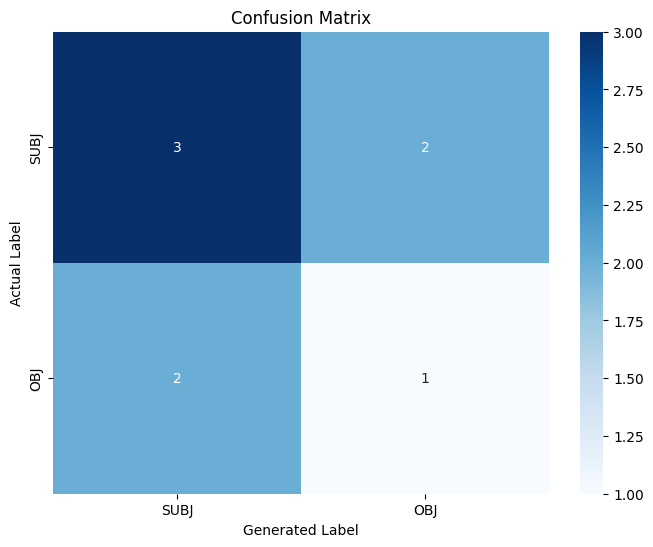

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming 'Actual Label' and 'Generated Label' are the column names
y_true = df['Actual Label']
y_pred = df['Generated Label']

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["SUBJ", "OBJ"])

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["SUBJ", "OBJ"], yticklabels=["SUBJ", "OBJ"])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Generated Label")
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Assuming df is your DataFrame with 'Actual Label' and 'Generated Label' columns
# Filter out rows with unexpected labels
expected_labels = ['SUBJ', 'OBJ']
mask = df['Actual Label'].isin(expected_labels) & df['Generated Label'].isin(expected_labels)
filtered_df = df[mask]

# Extract the filtered labels
y_true_filtered = filtered_df['Actual Label']
y_pred_filtered = filtered_df['Generated Label']

# Compute the classification report
report = classification_report(y_true_filtered, y_pred_filtered, target_names=expected_labels)
print(report)


              precision    recall  f1-score   support

        SUBJ       0.33      0.33      0.33         3
         OBJ       0.60      0.60      0.60         5

    accuracy                           0.50         8
   macro avg       0.47      0.47      0.47         8
weighted avg       0.50      0.50      0.50         8



In [ ]:
# Create a mask for non-matching entries
mismatch_mask = df['Actual Label'] != df['Generated Label']

# Apply the mask to the DataFrame to isolate non-matching rows
mismatched_rows = df[mismatch_mask]

# Display the mismatched rows
print(mismatched_rows)
